In [1]:
import numpy as np
import scipy
import argparse
import copy
import typing


from timeit import default_timer
from quadruped_gym.agents.whole_body_controller import com_velocity_estimator
from quadruped_gym.agents.whole_body_controller import gait_generator as gait_generator_lib
from quadruped_gym.agents.whole_body_controller import (
    locomotion_controller,
    openloop_gait_generator,
    raibert_swing_leg_controller,
    torque_stance_leg_controller,
)
from quadruped_gym.core.simulator import Simulator, Controller
from quadruped_gym.core.types import RobotObservation, RobotAction
from quadruped_gym.quadruped import a1_pybullet
from quadruped_gym.quadruped.a1_pybullet.actuator import ControlMode
from quadruped_gym.quadruped.a1_pybullet.simulator import SimulationParameters  # noqa: F401

_STANCE_DURATION_SECONDS = [0.13] * 4  # For faster trotting (v > 1.5 ms reduce this to 0.13s).

# Standing
# _DUTY_FACTOR = [1.] * 4
# _INIT_PHASE_FULL_CYCLE = [0., 0., 0., 0.]

# _INIT_LEG_STATE = (
#     gait_generator_lib.LegState.STANCE,
#     gait_generator_lib.LegState.STANCE,
#     gait_generator_lib.LegState.STANCE,
#     gait_generator_lib.LegState.STANCE,
# )

# Tripod
# _DUTY_FACTOR = [.8] * 4
# _INIT_PHASE_FULL_CYCLE = [0., 0.25, 0.5, 0.]

# _INIT_LEG_STATE = (
#     gait_generator_lib.LegState.STANCE,
#     gait_generator_lib.LegState.STANCE,
#     gait_generator_lib.LegState.STANCE,
#     gait_generator_lib.LegState.SWING,
# )

# Trotting
_DUTY_FACTOR = [0.6] * 4
_INIT_PHASE_FULL_CYCLE = [0.9, 0, 0, 0.9]

_INIT_LEG_STATE = (
    gait_generator_lib.LegState.SWING,
    gait_generator_lib.LegState.STANCE,
    gait_generator_lib.LegState.STANCE,
    gait_generator_lib.LegState.SWING,
)

def generate_example_linear_angular_speed(t):
    """Creates an example speed profile based on time for demo purpose."""
    vx = 0.6
    vy = 0.2
    wz = 0.8

    time_points = (0, 5, 10, 15, 20, 25, 30)
    speed_points = (
        (0, 0, 0, 0),
        (0, 0, 0, wz),
        (vx, 0, 0, 0),
        (0, 0, 0, -wz),
        (0, -vy, 0, 0),
        (0, 0, 0, 0),
        (0, 0, 0, wz),
    )

    speed = scipy.interpolate.interp1d(time_points, speed_points, kind="previous", fill_value="extrapolate", axis=0)(t)

    return speed[0:3], speed[3], False

def setup_controller(simulator: Simulator):
    """Demonstrates how to create a locomotion controller."""
    desired_speed = (0, 0)
    desired_twisting_speed = 0

    gait_generator = openloop_gait_generator.OpenloopGaitGenerator(
        simulator=simulator,
        stance_duration=_STANCE_DURATION_SECONDS,
        duty_factor=_DUTY_FACTOR,
        initial_leg_phase=_INIT_PHASE_FULL_CYCLE,
        initial_leg_state=_INIT_LEG_STATE,
    )
    window_size = 60
    state_estimator = com_velocity_estimator.COMVelocityEstimator(window_size=window_size)
    sw_controller = raibert_swing_leg_controller.RaibertSwingLegController(
        simulator = simulator,
        gait_generator=gait_generator,
        state_estimator=state_estimator,
        desired_speed=desired_speed,
        desired_twisting_speed=desired_twisting_speed,
        desired_height=simulator.robot_kinematics.MPC_BODY_HEIGHT,
        foot_clearance=0.01,
    )

    st_controller = torque_stance_leg_controller.TorqueStanceLegController(
        simulator=simulator,
        gait_generator=gait_generator,
        state_estimator=state_estimator,
        desired_speed=desired_speed,
        desired_twisting_speed=desired_twisting_speed,
        desired_body_height=simulator.robot_kinematics.MPC_BODY_HEIGHT,
    )

    controller = locomotion_controller.LocomotionController(
        simulator=simulator,
        gait_generator=gait_generator,
        state_estimator=state_estimator,
        swing_leg_controller=sw_controller,
        stance_leg_controller=st_controller,
    )
    return controller

class Logger:

    def __init__(self):
        self.data = []

    def update(self, data: typing.Union[np.ndarray, RobotAction, RobotObservation]):
        self.data.append(data)

    def collate(self):
        if isinstance(self.data[0], np.ndarray):
            all_data = np.stack(self.data, axis=0)
        elif isinstance(self.data[0], RobotAction):
            all_data = RobotAction(
                desired_motor_angles = np.stack([act.desired_motor_angles for act in self.data]),
                desired_motor_velocities = np.stack([act.desired_motor_velocities for act in self.data]),
                position_gain = np.stack([act.position_gain for act in self.data]),
                velocity_gain = np.stack([act.velocity_gain for act in self.data]),
                additional_torques = np.stack([act.additional_torques for act in self.data])
            )
        else:
            all_data = RobotObservation(
                base_position = np.stack([obs.base_position for obs in self.data]),
                base_velocity = np.stack([obs.base_velocity for obs in self.data]),
                base_orientation = np.stack([obs.base_orientation for obs in self.data]),
                base_rpy = np.stack([obs.base_rpy for obs in self.data]),
                base_rpy_rate = np.stack([obs.base_rpy_rate for obs in self.data]),
                motor_angles = np.stack([obs.motor_angles for obs in self.data]),
                motor_velocities = np.stack([obs.motor_velocities for obs in self.data]),
                motor_torques = np.stack([obs.motor_torques for obs in self.data]),
                foot_contacts = np.stack([obs.foot_contacts for obs in self.data]),
                foot_contact_forces = np.stack([obs.foot_contact_forces for obs in self.data]),
                foot_positions = np.stack([obs.foot_positions for obs in self.data])
            )
        return all_data

def test_simulation_with_controller(simulator: Simulator, controller: Controller, max_time_steps: int):
    obs_logger = Logger()
    act_logger = Logger()


    obs = simulator.reset()
    current_time_robot = simulator.time_since_reset
    current_time_wall = default_timer()

    start_time_robot = current_time_robot
    start_time_wall = current_time_wall 

    for i in range(max_time_steps):
        current_time_robot = simulator.time_since_reset
        current_time_wall = default_timer()
        
        lin_speed, ang_speed, e_stop = generate_example_linear_angular_speed(current_time_robot)
        if e_stop:
            break

        controller.swing_leg_controller.desired_speed = lin_speed
        controller.swing_leg_controller.desired_twisting_speed = ang_speed
        controller.stance_leg_controller.desired_speed = lin_speed
        controller.stance_leg_controller.desired_twisting_speed = ang_speed
        controller.update(obs, current_time_robot)

        action, info = controller.get_action()
        obs_logger.update(copy.deepcopy(obs))
        act_logger.update(copy.deepcopy(action))
        obs = simulator.step(action)

    observation_history = obs_logger.collate()
    action_history = act_logger.collate()
    return observation_history, action_history

if __name__ == "__main__":

    simulator = a1_pybullet.A1PyBulletSimulator(
        sim_params=SimulationParameters(
            sim_time_step_s=0.001,
            n_action_repeat=1,
            enable_rendering=False,
            enable_clip_motor_commands=False,
            enable_action_filter=False,
            actuator_control_mode = ControlMode.HYBRID
        )
    )
    obs = simulator.reset()
    controller = setup_controller(simulator)
    controller.reset()

    print('Successfully set up controller')

    obs_hist, act_hist = test_simulation_with_controller(simulator, controller, max_time_steps = 10000)

pybullet build time: Dec  1 2021 18:33:43


argv[0]=
b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
baseSuccessfully set up controller


17.79953049056143


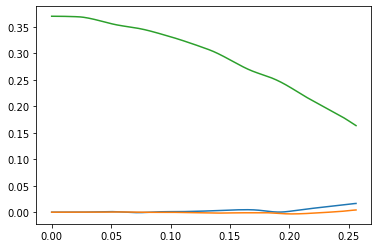

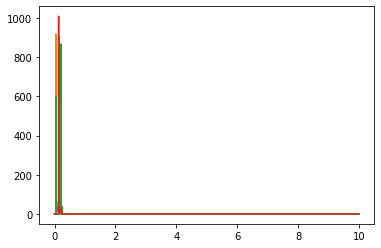

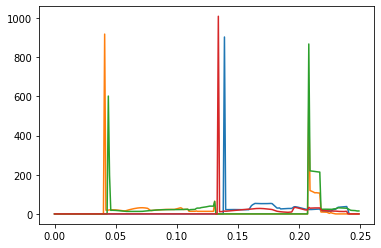

In [4]:
import matplotlib.pyplot as plt 

time = np.linspace(0, 10000 * 0.001 * 1, 10000)

plt.figure()
for i in range(obs_hist.base_position.shape[1]):
    plt.plot(time, obs_hist.base_position[:,i])
plt.figure()
for i in range(obs_hist.foot_contact_forces.shape[1]):
    plt.plot(time, obs_hist.foot_contact_forces[:,i])
plt.figure()
for i in range(obs_hist.foot_contact_forces.shape[1]):
    plt.plot(time[:250], obs_hist.foot_contact_forces[:250,i])
print(np.mean(obs_hist.foot_contact_forces[:250]))